In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftshift
from scipy import signal
import os, wave, struct
from IPython.display import Audio

Construction of the analysis and synthesis filters:

In [28]:
N = 16 # number of channels
L = 8 # number of taps
M = L*N
range = np.arange(M)

sr = 44100 # sampling rate
#sr = 48000 # sampling rate

cutoff_freq_Hz = sr/(2*N) # cutoff frequency for the prototype filter (Hz)
cutoff_freq = np.pi/(N) # cutoff frequency for the prototype filter (normalize by pi)

# prototype filter of length M through Kaiser window approach
def prototype_filter(proto_len, cutoff): 
    
    len_range = np.arange(proto_len)

    # choice of Kaiser window
    beta = 14 # parameter of the Kaiser window
    w = np.kaiser(M, beta)

    v = np.divide(np.sin(cutoff * (len_range-0.5*proto_len)), np.pi * (len_range-0.5*proto_len))
    if proto_len % 2 == 0:
        v[int(proto_len/2)] = cutoff/np.pi
 
    filter = np.multiply(v, w)
    return filter

# cosine modulation factors
def cos_modulation(n, k):
    phi_k = (-1)**k + np.pi/4
    result = np.cos((k+0.5) * (n-(M-1)/2) * (np.pi/N) + phi_k)
    return result 

C:\Users\HPR2G~1\AppData\Local\Temp/ipykernel_20000/2932462047.py:21: RuntimeWarning: invalid value encountered in true_divide
  v = np.divide(np.sin(cutoff * (len_range-0.5*proto_len)), np.pi * (len_range-0.5*proto_len))


Text(0.5, 0, 'Normalized frequency [cycles per sample]')

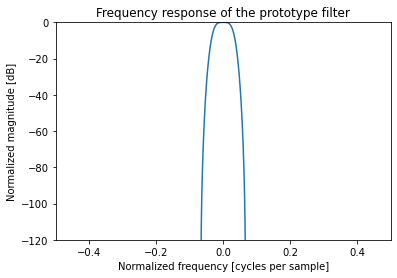

In [29]:
windowed_filter = prototype_filter(M, cutoff_freq)

plt.figure()
A = fft(windowed_filter, 2048) / (len(windowed_filter)/2.0)
freq = np.linspace(-0.5, 0.5, len(A))
response = 20 * np.log10(np.abs(fftshift(A / abs(A).max())))
plt.plot(freq, response)
plt.axis([-0.5, 0.5, -120, 0])
plt.title("Frequency response of the prototype filter")
plt.ylabel("Normalized magnitude [dB]")
plt.xlabel("Normalized frequency [cycles per sample]")

In [101]:
# analysis and synthesis filters
h_analysis = np.zeros((N, M))
h_analysis[0] = prototype_filter(M, cutoff_freq)
h_synthesis = np.zeros((N, M))
h_synthesis[0] = h_analysis[0][::-1]

for k in np.arange(1, N):
    cos_mod = cos_modulation(range, k)
    h_analysis[k] = np.multiply(h_analysis[0], cos_mod)

    # defining the synthesis filters as time-reverse of the analysis filters
    h_synthesis[k] = h_analysis[k][::-1]  

C:\Anaconda\envs\env_ml\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


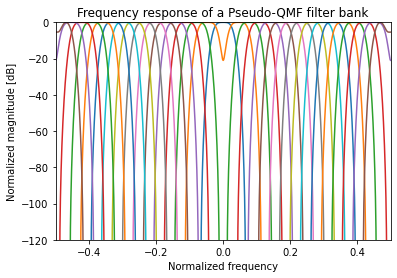

In [102]:
plt.figure()

for k in np.arange(N):
    windowed_filter = h_analysis[k]

    A = fft(windowed_filter, 2048) / (len(windowed_filter)/2.0)
    freq = np.linspace(-0.5, 0.5, len(A))
    response = 20 * np.log10(np.abs(fftshift(A / abs(A).max())))
    plt.plot(freq, response)
    plt.axis([-0.5, 0.5, -120, 0])
    plt.title("Frequency response of a Pseudo-QMF filter bank")
    plt.ylabel("Normalized magnitude [dB]")
    plt.xlabel("Normalized frequency")

Application to audio signals:

In [32]:
def conv(signal_in, h):
    signal_out = np.convolve(signal_in, h, mode='same')
    return(signal_out)

In [33]:
def PQMF_analysis(signal_in, n_channels, n_taps):
    len_filter = n_channels*n_taps
    decomposition = np.zeros((n_channels, len(signal_in)))

    for k in np.arange(n_channels):
        decomposition[k] = conv(signal_in, h_analysis[k])

    return decomposition 

In [34]:
def PQMF_synthesis(decomposition, n_channels, n_taps):

    reconstruction = 0
    for k in np.arange(n_channels):
        reconstruction += conv(decomposition[k], h_synthesis[k])

    return reconstruction 

In [35]:
def load_sound(file):
    return wave.open(file, 'rb')
data_path = os.getcwd()
filename = 'song.wav'
sound = os.path.join(data_path, filename)
wavefile = load_sound(sound)
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
test_signal = np.array(data)

Original signal:

In [37]:
Audio(test_signal, rate=Fs)

Decomposed and reconstructed signals:

In [38]:
decomposed_signal = PQMF_analysis(test_signal, N, L)
print(decomposed_signal.shape)

(16, 1233670)


In [43]:
Audio(decomposed_signal[1],rate=Fs)

In [41]:
reconstructed_signal = PQMF_synthesis(decomposed_signal, N, L)
print(reconstructed_signal.shape)

(1233670,)


In [42]:
Audio(reconstructed_signal, rate=Fs)